# Color GAN
*   **Goal:** Black & white to rgb images
*   **Dataset:** ImageNet/COCO-dataset

# Algorithm
*   **Cost function V(D,G):** log(D(x)) + log(1- D(G(x))), could possibly add a l1 norm accounting for the difference between groundtruth image and generated image
*   **Discrimnator (D):** maximize cost function (be able to give high probability for real x vs. generated x)
*   **Generator (G):** minimize the cost function (confuses discriminator such that discriminator gives lower probability for real x vs. generated x, e.g. 50%)
*   **Optimization:** use minibatch, ADAM optimizer (lr = 0.0001 or .00005,
momentum β1 = 0.5, β2 = 0.999.)
*   **Regularization:** try both L1 & L2 for G


In [1]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [27]:
# Import packages
import numpy as np
import math
import os
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
from torch.utils import data
from torch.nn.utils import spectral_norm
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1
from PIL import ImageFile
from matplotlib import pyplot
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
1.5.0+cu101


In [4]:
# make sure go to the project path
project_path = "/gdrive/My Drive/Colab Notebooks/GAN"
os.chdir(project_path)
!ls

Color_GAN_Nicole.ipynb	Dataset  small_Color_GAN_Nicole.ipynb


In [5]:
# CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## Load Dataset

In [0]:
#download cocodataset into google drive
# !wget http://images.cocodataset.org/zips/train2017.zip
# !unzip train2017.zip

In [0]:
# load_data
def load_data(data_folder, batch_size, train):
  '''
    PARAMETERS: 
      data_folder: path to dataset (make sure you're in project folder)
      batch_size: how many images in a batch
      train: boolean True/False

    RETURN:
      data_loader with random sample with batch_size from either "train" or "test" dataset
  '''
  transform = {
    'train': transforms.Compose(
        [transforms.Resize([224,224]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                   std=[0.229, 0.224, 0.225])
            ]),
    'test': transforms.Compose(
        [transforms.Resize([224, 224]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
  }
  data = torchvision.datasets.ImageFolder(root = data_folder, transform=transform['train' if train else 'test'])
  data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
  return data_loader 

In [0]:
b_size = 128
# set up datafolder and read data
datafolder = "Dataset"
train_data = load_data(data_folder = datafolder, batch_size = b_size , train = True)  #100 training images
test_data = load_data(data_folder = datafolder, batch_size = b_size , train = True)  #50 testing images

# dataiter for iterating data randomly 
train_dataiter = iter(train_data)
test_dataiter = iter(test_data)

In [8]:
train_real, labels = train_dataiter.next() #get one batch of train data
print(train_real.shape) # images are in batch_size x channels(3) x width x height

torch.Size([128, 3, 224, 224])


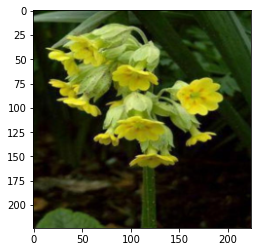

In [9]:
show_imgs(train_real[1,:,:,:])  #example of train data

## Discriminator + Generator Structure

In [0]:
class Discriminator_Nicole(torch.nn.Module):
    def __init__(self, inp_dim= 3*224*224, alpha=0.1, kernel_size = 3, padding = 1, stride = 2):
        super(Discriminator_Nicole, self).__init__()
        
        self.net = nn.Sequential(
            # (conv + norm + relu) * 2
            nn.Conv2d(3, 64, kernel_size, stride, padding),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(alpha),

            nn.Conv2d(64, 64, kernel_size, stride, padding),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(alpha),

            # pooling
            nn.MaxPool2d(2),

            # (conv + norm + relu) * 2
            nn.Conv2d(64, 128, kernel_size, stride, padding),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha),

            nn.Conv2d(128, 256, kernel_size, stride, padding),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            
            #pooling
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(256 * 3 * 3, 500)
        self.nonlin = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(500, 1)
        
    def forward(self, x):
      x = self.net(x)
      x = x.view(x.size(0), 256*3*3) #flattening x
      x = self.nonlin(self.fc1(x))
      x = self.fc2(x)
      x = torch.sigmoid(x)
      return x

    def weight_initial(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
        if isinstance(m, nn.ConvTranspose2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))

In [15]:
D = Discriminator_Nicole()
output = D(train_real)
print(output.shape)
# print(output)

torch.Size([128, 1])


In [0]:
class Generator_Nicole(nn.Module):
  def __init__(self, input_size = 224*224, alpha = .2, kernel_size = 3, padding = 1, output_padding = 1, stride = 2):
    super(Generator_Nicole, self).__init__()

    # (conv + norm + relu) * 5 - > reduce size
    self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(alpha, inplace=False))
    
    self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(alpha, inplace=False))
    
    self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(alpha, inplace=False))
    
    self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha, inplace=False))
    
    self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha, inplace=False))

    # (deconv + norm + relu) * 5 - > increase size
    self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU())
    
    self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(128+128, 64, kernel_size, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU())
    
    self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(64+64, 32, kernel_size, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU())
    
    self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(32+32, 16, kernel_size, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU())
    
    self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(16+16, 3, kernel_size, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(3),
            nn.ReLU())


  def forward(self, x):
    x = self.conv1(x)
    p1 = x
    x = self.conv2(x)
    p2 = x
    x = self.conv3(x)
    p3 = x
    x = self.conv4(x)
    p4 = x
    x = self.conv5(x)
    
    x = self.deconv1(x)
    x = torch.cat((x, p4), 1) 
    x = self.deconv2(x)
    x = torch.cat((x, p3), 1) 
    x = self.deconv3(x)
    x = torch.cat((x, p2), 1) 
    x = self.deconv4(x)
    x = torch.cat((x, p1), 1) 
    x = self.deconv5(x)
    
    x = torch.tanh(x)
    return x

  def weight_initial(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, math.sqrt(2. / n))
      if isinstance(m, nn.ConvTranspose2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, math.sqrt(2. / n))

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])


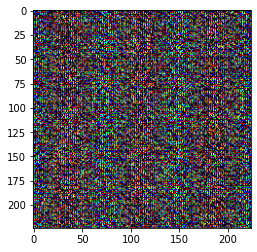

In [23]:
G = Generator_Nicole()
x = torch.randn(1,1,224,224)
o = G(x)
print(o.shape)

img = o.detach().squeeze()
print(img.shape)
plt.imshow(img.permute(1, 2, 0))

## Training

In [0]:
import torch.optim as optim
from torch.autograd import Variable

In [0]:
def train(D, G, D_opt, G_opt, criterion, L1loss, lmbda, num_e):
  '''
  PARAMTER:
    D: discriminator
    G: generator
    D_opt: discriminator Optimizer
    num_e: number of epoches
  '''
  
  LOSS = {}
  LOSS["D_loss"] = []
  LOSS["G_loss"] = []


  for e in range(num_e):
    train_dataiter = iter(train_data)
    print("epoch: %d start" % (e+1))
    D_loss = []
    D_out_real = []
    D_out_fake = []
    G_loss = []

    for train_real, _ in train_dataiter: 
      b_size = train_real.shape[0]

      ##############
      # D Training #
      ##############
      D_opt.zero_grad()
      train_real = train_real.to(device)
      lab_real, lab_fake = torch.FloatTensor(b_size).uniform_(.9, 1).to(device), torch.FloatTensor(b_size).uniform_(0, .1).to(device)
      # corresponding grayscale images
      images = train_real.clone().cpu() 
      images = [torchvision.transforms.ToPILImage()(x) for x in images]
      images = [torchvision.transforms.Grayscale()(x) for x in images]
      images = [torchvision.transforms.ToTensor()(x) for x in images]
      train_real_gray = torch.stack(images).to(device)

      # D Loss for real
      n = (torch.randn(train_real.size()) * .1) # add noise to image to make it harder for discriminator
      n = n.to(device)
      train_real = train_real + n
      D_out = D(train_real)
      lossD_real = criterion(D_out, lab_real)

      # D Loss for fake
      G_fake_out = G(train_real_gray)
      D_fake_out = D(G_fake_out.detach())

      lossD_fake = criterion(D_fake_out, lab_fake)

      # D Loss total
      lossD = lossD_real + lossD_fake
      lossD.backward()
      D_opt.step()

      D_out_real.append(D_out)
      print("D_out_real: %f" % D_out.mean())
      D_out_fake.append(D_fake_out)
      print("D_out_fake: %f" % D_fake_out.mean())
      D_loss.append(lossD)
      print("D_loss: %f" % lossD)


      ##############
      # G Training #
      ##############
      G_opt.zero_grad()

      # G Loss + perceptu norm Loss between generated rgb image and groundtruth image
      D_G_out = D(G_fake_out)
      lossG = criterion(D_G_out, lab_real) #Loss for GAN LOSS
      lossG_L1 = L1loss(G_fake_out.view(G_fake_out.size(0),-1), train_real.view(train_real.size(0),-1)) #Loss for output rgb and real rgb image
      LossGAN_L1 = lossG + lmbda * lossG_L1
      LossGAN_L1.backward()
      G_opt.step()

      G_loss.append(LossGAN_L1)
      print("G_loss: %f" % LossGAN_L1)

  
    print("epoch %d finished" % (e+1))
    LOSS["D_loss"].append(torch.mean(torch.stack(D_loss)))
    LOSS["G_loss"].append(torch.mean(torch.stack(G_loss)))

    print("test on 16 images:")
    test_dataiter = iter(test_data)
    test_real, _ = test_dataiter.next()
    test_images = test_real.clone().cpu() 
    test_images = [torchvision.transforms.ToPILImage()(x) for x in test_images]
    test_images = [torchvision.transforms.Grayscale()(x) for x in test_images]
    test_images = [torchvision.transforms.ToTensor()(x) for x in test_images]
    test_real_gray = torch.stack(test_images).to(device)

    test_img_orig = test_real[0:16,...]
    test_img_gray = test_real_gray[0:16,...]
    G_test_out = G(test_img_gray)
    show_imgs(test_img_orig)
    show_imgs(test_img_gray)
    show_imgs(G_test_out)

  return LOSS

In [0]:
G = Generator_Nicole().to(device)
D = Discriminator_Nicole().to(device)
D.weight_initial()
G.weight_initial()
G.train()
D.train()
# for m in G.modules():
#   if isinstance(m, nn.Conv2d):
#     print(m.weight.data)

h, w = 224, 224
lr = .0001
beta1 = .5
lmbda = .0001
num_e = 20

criterion = nn.BCELoss()
L1loss = nn.L1Loss()
D_opt = optim.Adam(D.parameters(), lr=lr, betas = (beta1, .999))
G_opt = optim.Adam(G.parameters(), lr=lr, betas = (beta1, .999))

In [43]:
# train
G = G.to(device)
D = D.to(device)
G.train()
D.train()
training_loss = train(D, G, D_opt, G_opt, criterion, L1loss, lmbda, num_e)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
def plot_history(d_hist, g_hist, e, a_hist= None):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d_hist, label='discriminator')
	pyplot.plot(g_hist, label='generator')
	pyplot.legend()
	pyplot.savefig('/gdrive/My Drive/Colab Notebooks/GAN/smallGAN_results_%d.png' %e)
	pyplot.close()

In [0]:
# save model
import datetime
date = datetime.datetime.now().isoformat(' ', 'seconds')[5:10]

D_path = "/gdrive/My Drive/Colab Notebooks/GAN/smallGAN_D_%d_%s.pth.tar" % (num_e,date)
G_path = "/gdrive/My Drive/Colab Notebooks/GAN/smallGAN_G_%d_%s.pth.tar" % (num_e,date)
torch.save(D.state_dict(), D_path)
torch.save(G.state_dict(), G_path)

d_hist = training_loss["D_loss"]
g_hist = training_loss["G_loss"]
plot_history(d_hist, g_hist, e = num_e)

In [0]:
# load model
D_path = "/gdrive/My Drive/Colab Notebooks/GAN trained model/D_1e_noise_05-22.pth.tar"
G_path = "/gdrive/My Drive/Colab Notebooks/GAN trained model/G_1e_noise_05-22.pth.tar"

D = Discriminator_Nicole()
D.load_state_dict(torch.load(D_path))
G = Generator_Nicole()
G.load_state_dict(torch.load(G_path))
G.eval()
D.eval()

Discriminator output: 

tensor(0.0704, grad_fn=<MeanBackward0>)


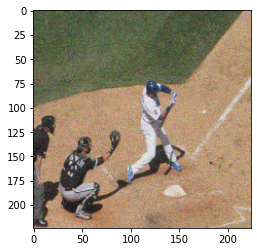

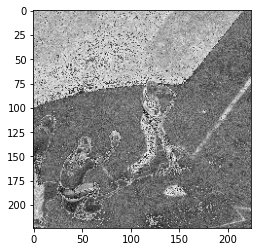

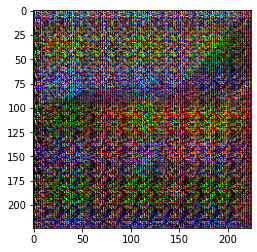

In [0]:
# visualize result
train_real, labels = train_dataiter.next()
train_real = train_real + torch.randn(train_real.size()) * .1
# train_real.to(device)
D_out = D(train_real)
print("Discriminator output: \n")
print(D_out.mean())


images = train_real.clone().cpu() 
images = [torchvision.transforms.ToPILImage()(x) for x in images]
images = [torchvision.transforms.Grayscale()(x) for x in images]
images = [torchvision.transforms.ToTensor()(x) for x in images]
train_real_gray = torch.stack(images).cpu()

show_imgs(train_real[3,:,:,:])

gray = train_real_gray[3,:,:,:]
show_imgs(gray)

G_out = G(gray.unsqueeze(0))
show_imgs(G_out)

In [0]:
torch.randn(train_real.size()) * .1

tensor([[[[ 2.7192e-01, -1.1364e-01, -1.1240e-02,  ...,  2.0994e-02,
            3.2021e-02, -2.5156e-02],
          [-2.2548e-02,  1.5788e-02, -9.6813e-02,  ...,  5.6745e-02,
           -4.8930e-02,  1.4755e-01],
          [ 6.0239e-02,  3.5495e-02,  9.1955e-02,  ...,  1.6635e-02,
            4.9295e-02,  4.9915e-02],
          ...,
          [-3.4953e-03,  2.3741e-02,  6.0511e-02,  ..., -1.3055e-01,
           -1.2912e-01,  8.0498e-02],
          [ 8.9657e-02,  1.2680e-01,  5.6265e-03,  ...,  1.4731e-01,
           -8.4889e-02,  7.1525e-02],
          [-2.7810e-02, -1.4645e-02,  1.7835e-02,  ...,  6.4113e-02,
            5.4808e-02,  9.6344e-02]],

         [[ 4.9253e-02,  4.6124e-02, -4.0693e-03,  ...,  7.8297e-02,
            1.4651e-03,  9.2739e-02],
          [ 1.0887e-01, -3.1864e-03, -1.2353e-01,  ...,  6.5025e-02,
           -1.0335e-01,  2.7904e-02],
          [ 8.4048e-02, -1.6415e-01,  5.5395e-02,  ..., -1.2172e-02,
           -1.1429e-01,  9.8497e-02],
          ...,
     